In [2]:
pip install openai python-dotenv Pillow numpy

In [84]:
import os

import openai
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]


client = OpenAI()

file = client.files.create(
    file=open("parking_violation.csv", "rb"), purpose="assistants"
)

assistant = client.beta.assistants.create(
    name="Data visualizer",
    description="You are great at creating beautiful data visualizations. You analyze data present in .csv files, understand trends, and come up with data visualizations relevant to those trends. You also share a brief text summary of the trends observed.",
    model="gpt-4o",
    tools=[{"type": "code_interpreter"}],
    tool_resources={"code_interpreter": {"file_ids": [file.id]}},
)

thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Create 3 data visualizations using two columns or more based on the trends in this file.",
            "attachments": [
                {"file_id": file.id, "tools": [{"type": "code_interpreter"}]}
            ],
        }
    ]
)

# Submit the thread to the assistant (as a new run).
run = client.beta.threads.runs.create(thread_id=thread.id, assistant_id=assistant.id)
print(f"👉 Run Created: {run.id}")


👉 Run Created: run_oD1jvn4pTXAB4CDBAJPTkWDH


In [85]:
import time

# Wait for run to complete.
while run.status != "completed":
    run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
    print(f"🏃 Run Status: {run.status}")
    time.sleep(1)
else:
    print(f"🏁 Run Completed!")


🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: in_progress
🏃 Run Status: completed
🏁 Run Completed!


In [100]:
message_response = client.beta.threads.messages.list(thread_id=thread.id)
message_response.data

[Message(id='msg_SyRUOHSngqmxkbInm1vVdj9d', assistant_id='asst_peNnLIMHbsAvNv6ZmFCgKPSa', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-IJeN3F3TZrJqqMcQal87BXC0', detail=None), type='image_file'), ImageFileContentBlock(image_file=ImageFile(file_id='file-RDTWnWYvrf7MI08NxXzDSk9w', detail=None), type='image_file'), ImageFileContentBlock(image_file=ImageFile(file_id='file-OHK8Uuhe8kmSBqCL0QIou978', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here are the three data visualizations based on the trends in the file:\n\n1. **Top 10 Vehicle Makes by Number of Violations**:\n    - This bar plot shows the ten vehicle makes with the highest number of violations. For example, Toyota and Honda are among the top violators.\n\n2. **Violation Distribution by Violation Code**:\n    - This bar plot displays the distribution of violations by their respective violation codes. Certain codes occur more frequently t

In [101]:

image_data = client.files.content(message_response.data[0].content[0].image_file.file_id)
image_data_bytes = image_data.read()

with open("my-image.png", "wb") as file:
    file.write(image_data_bytes)

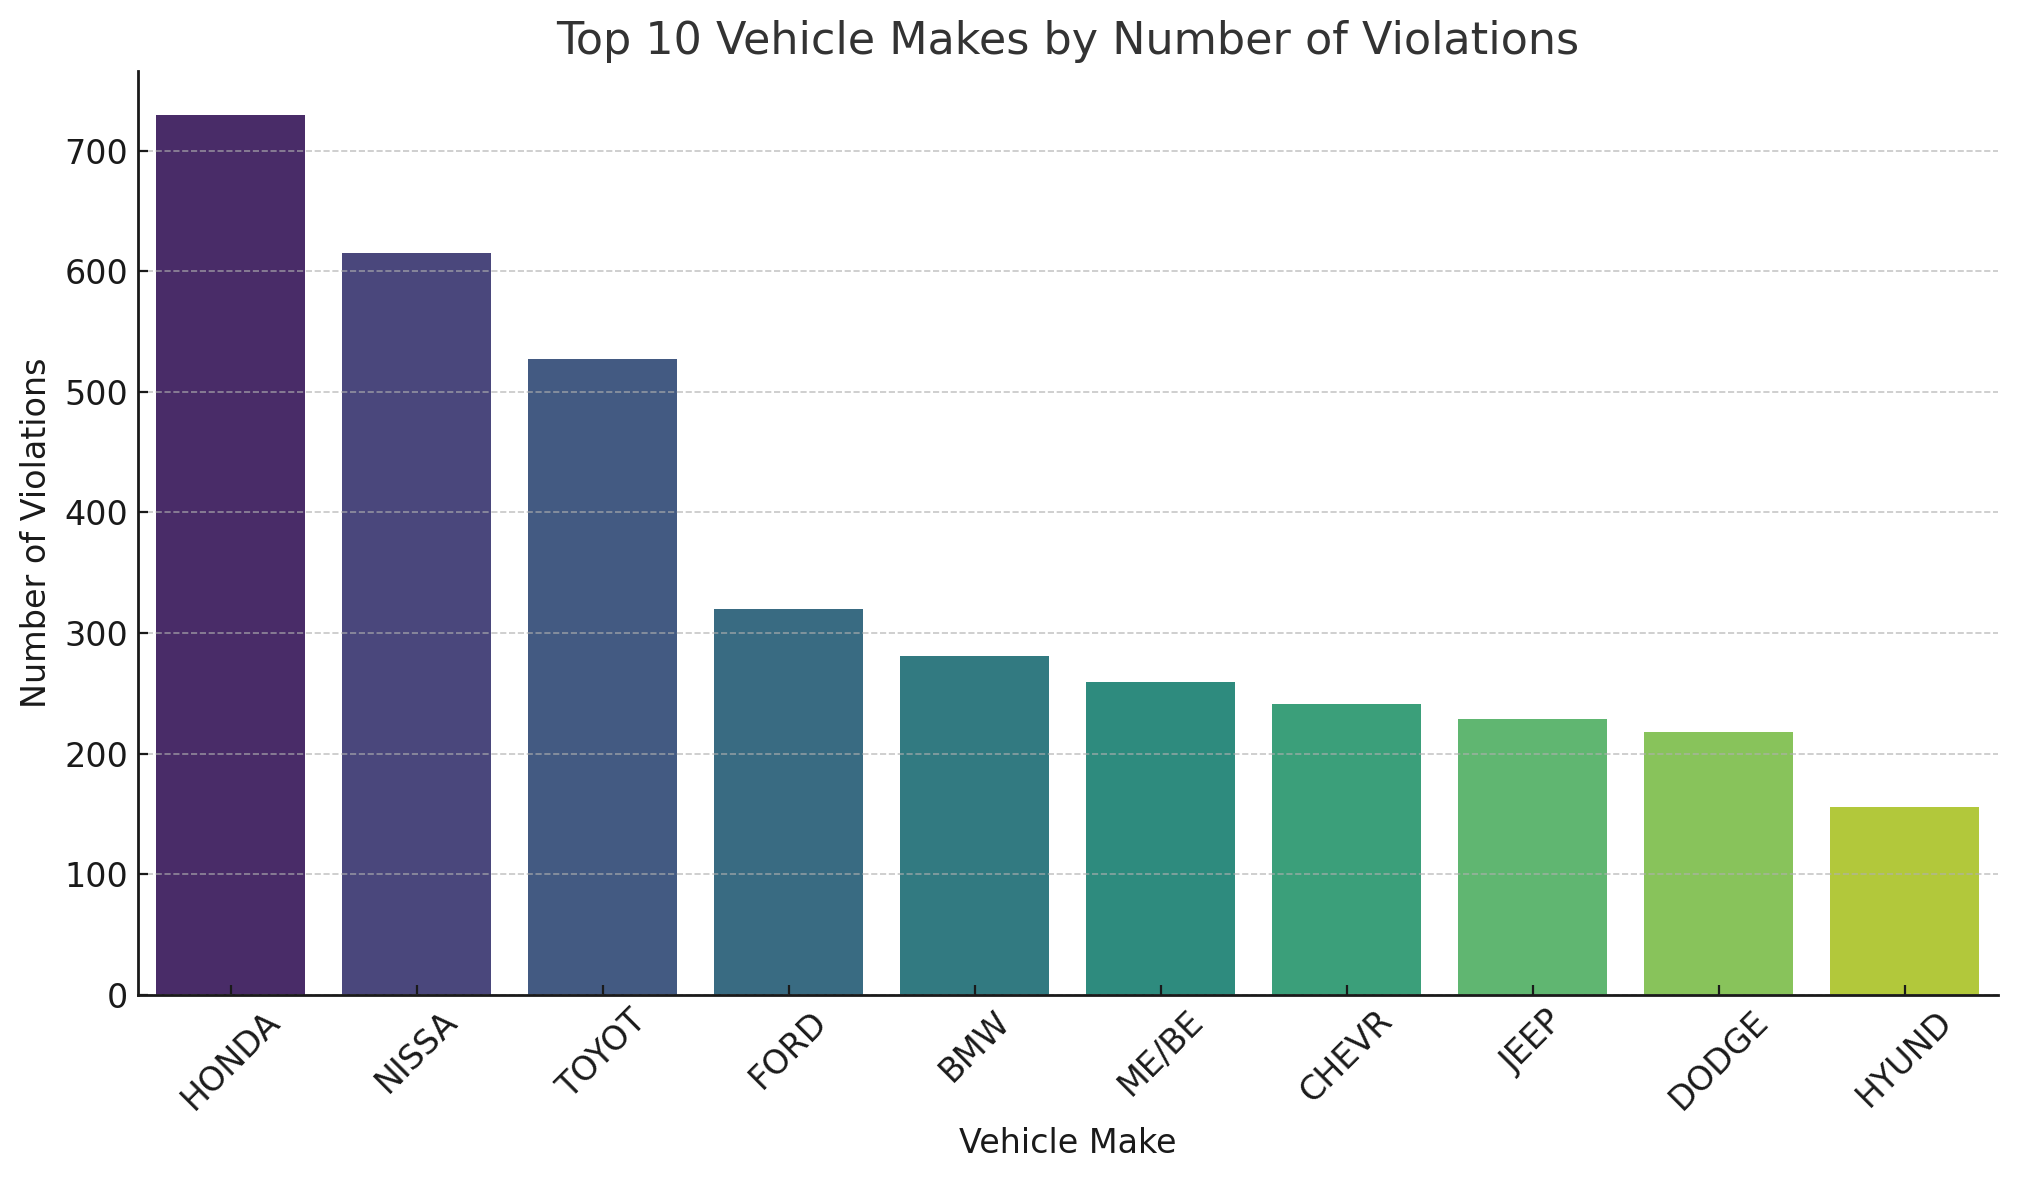

PNG (2017, 1180) RGBA


In [102]:
from PIL import Image

# Open an image file
image = Image.open('my-image.png')

# Display image
image.show()

# If you want to convert the image to a numpy array for further processing
import numpy as np
image_array = np.array(image)

# Print image details
print(image.format, image.size, image.mode)


In [82]:
pip install pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.3 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
